In [74]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, add_constant, coint, pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import AutoReg, VAR
from geopy.distance import great_circle
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import pandas as pd
import numpy as np
import math

In [75]:
data = pd.read_csv(r"/Users/main/Vault/Thesis/Data/pm25_weer.csv")
data["FH"] = data["FH"] * 0.36
data.drop(data.iloc[:, 0:7], axis=1, inplace=True)
data.drop(data.iloc[:, 1:5], axis=1, inplace=True)
{
data.drop(["jaar", "maand", "weeknummer", "#STN", "timestamp", 
"components", "dag", "tijd", "uur", "datum", "sensortype", "weekdag", "U", "H", "T"], 
axis=1, inplace=True)
}

{None}

In [76]:
grouped_df = data.groupby(by=["YYYYMMDD", "tag"]).mean().copy().reset_index()
grouped_df.rename(columns={"DD":"Angle", "FH":"Wind"}, inplace=True)
grouped_df["Date"] = pd.to_datetime(grouped_df["YYYYMMDD"].astype(str))
grouped_df.set_index("Date", inplace=True)
grouped_df

,YYYYMMDD,tag,pm25,latitude,longitude,Angle,Wind
Date,,,,,,,
2019-06-25,20190625,Amsterdam,16.602565,52.359714,4.866208,170.434783,12.991304
2019-06-25,20190625,Beverwijk,18.822000,52.492369,4.650824,276.000000,12.960000
2019-06-26,20190626,Amsterdam,21.974609,52.359714,4.866208,126.521739,16.747826
2019-06-26,20190626,Beverwijk,2.851417,52.485871,4.657933,19.166667,19.200000
2019-06-27,20190627,Amsterdam,4.484500,52.359714,4.866208,37.916667,17.700000
...,...,...,...,...,...,...,...
2022-10-22,20221022,IJmuiden,6.112711,52.456553,4.608536,187.169811,17.954717
2022-10-22,20221022,Uithoorn,7.120000,52.238091,4.808229,186.250000,18.000000
2022-10-22,20221022,Velsen-Noord,6.428708,52.472797,4.648964,186.250000,18.000000


In [77]:
Locations = grouped_df["tag"].unique()
LocDict = dict()

for i in range(len(Locations)):
    LocDict[Locations[i]] = (grouped_df[grouped_df.tag == Locations[i]]["latitude"].mean(), 
    grouped_df[grouped_df.tag == Locations[i]]["longitude"].mean())
    
    
grouped_df.drop(columns=["YYYYMMDD", "latitude", "longitude"], inplace=True)
LocDict

{'Amsterdam': (52.385565471780744, 4.901327224364789),
 'Beverwijk': (52.486366756022534, 4.658584737682753),
 'Heemskerk': (52.50593616684639, 4.671953092146708),
 'Wijk aan Zee': (52.493443775747366, 4.59824578234632),
 'Velsen-Noord': (52.47382287197285, 4.647238399148998),
 'Driehuis': (52.447194827537714, 4.636977030738782),
 'IJmuiden': (52.45820717461739, 4.615567828011168),
 'Velsen-Zuid': (52.46234499999992, 4.637255999999981),
 'Zaandam': (52.45848175659801, 4.824912486862412),
 'Koog aan de Zaan': (52.46407900000035, 4.811263999999972),
 'Uithoorn': (52.23809099999961, 4.8082289999999865)}

In [93]:
def get_bearing(coor1, coor2):
    dLon = (coor2[1] - coor1[1])
    y = math.sin(dLon) * math.cos(coor2[0])
    x = math.cos(coor1[0]) * math.sin(coor2[0]) - math.sin(coor1[0]) * math.cos(coor2[0]) * math.cos(dLon)
    brng = math.atan2(y, x)
    brng = np.rad2deg(brng)
    return brng

W = np.zeros((len(LocDict), len(LocDict)))
AngleMatrix = np.zeros((len(LocDict), len(LocDict)))

for i in range(len(LocDict)):
    for j in range(len(LocDict)):
        if i != j:
            theta = get_bearing(LocDict[Locations[i]], LocDict[Locations[j]])
            W[i, j] = great_circle(LocDict[Locations[i]], LocDict[Locations[j]]).km
            AngleMatrix[i, j] = theta

In [79]:
UniqueNames = grouped_df.tag.unique()

PolDict = {elem : pd.DataFrame() for elem in UniqueNames}
AngleDict = {elem : pd.DataFrame() for elem in UniqueNames}
WindDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in PolDict.keys():
    PolDict[key] = grouped_df[:][grouped_df.tag == key]
    PolDict[key].rename(columns={"pm25":key}, inplace=True)
    PolDict[key].drop(["Angle", "Wind"], axis=1, inplace=True)
    del PolDict[key]["tag"]

    AngleDict[key] = grouped_df[:][grouped_df.tag == key]
    AngleDict[key].rename(columns={"Angle":key}, inplace=True)
    AngleDict[key].drop(["pm25", "Wind"], axis=1 , inplace=True)
    del AngleDict[key]["tag"]

    WindDict[key] = grouped_df[:][grouped_df.tag == key]
    WindDict[key].rename(columns={"Wind":key}, inplace=True)
    WindDict[key].drop(["pm25", "Angle"], axis=1 , inplace=True)
    del WindDict[key]["tag"]

In [80]:
df_pol = pd.DataFrame()
df_angle = pd.DataFrame()
df_wind = pd.DataFrame()

for key in PolDict:
    df_pol = df_pol.combine_first(PolDict[key])
    df_angle = df_angle.combine_first(AngleDict[key])
    df_wind = df_wind.combine_first(WindDict[key])

In [81]:
for column in df_pol:
    median_values = (df_pol[column].median(), df_angle[column].median(), df_wind[column].median())
    df_pol[column].fillna(value=median_values[0], inplace = True)
    df_angle[column].fillna(value=median_values[1], inplace = True)
    df_wind[column].fillna(value=median_values[2], inplace = True)

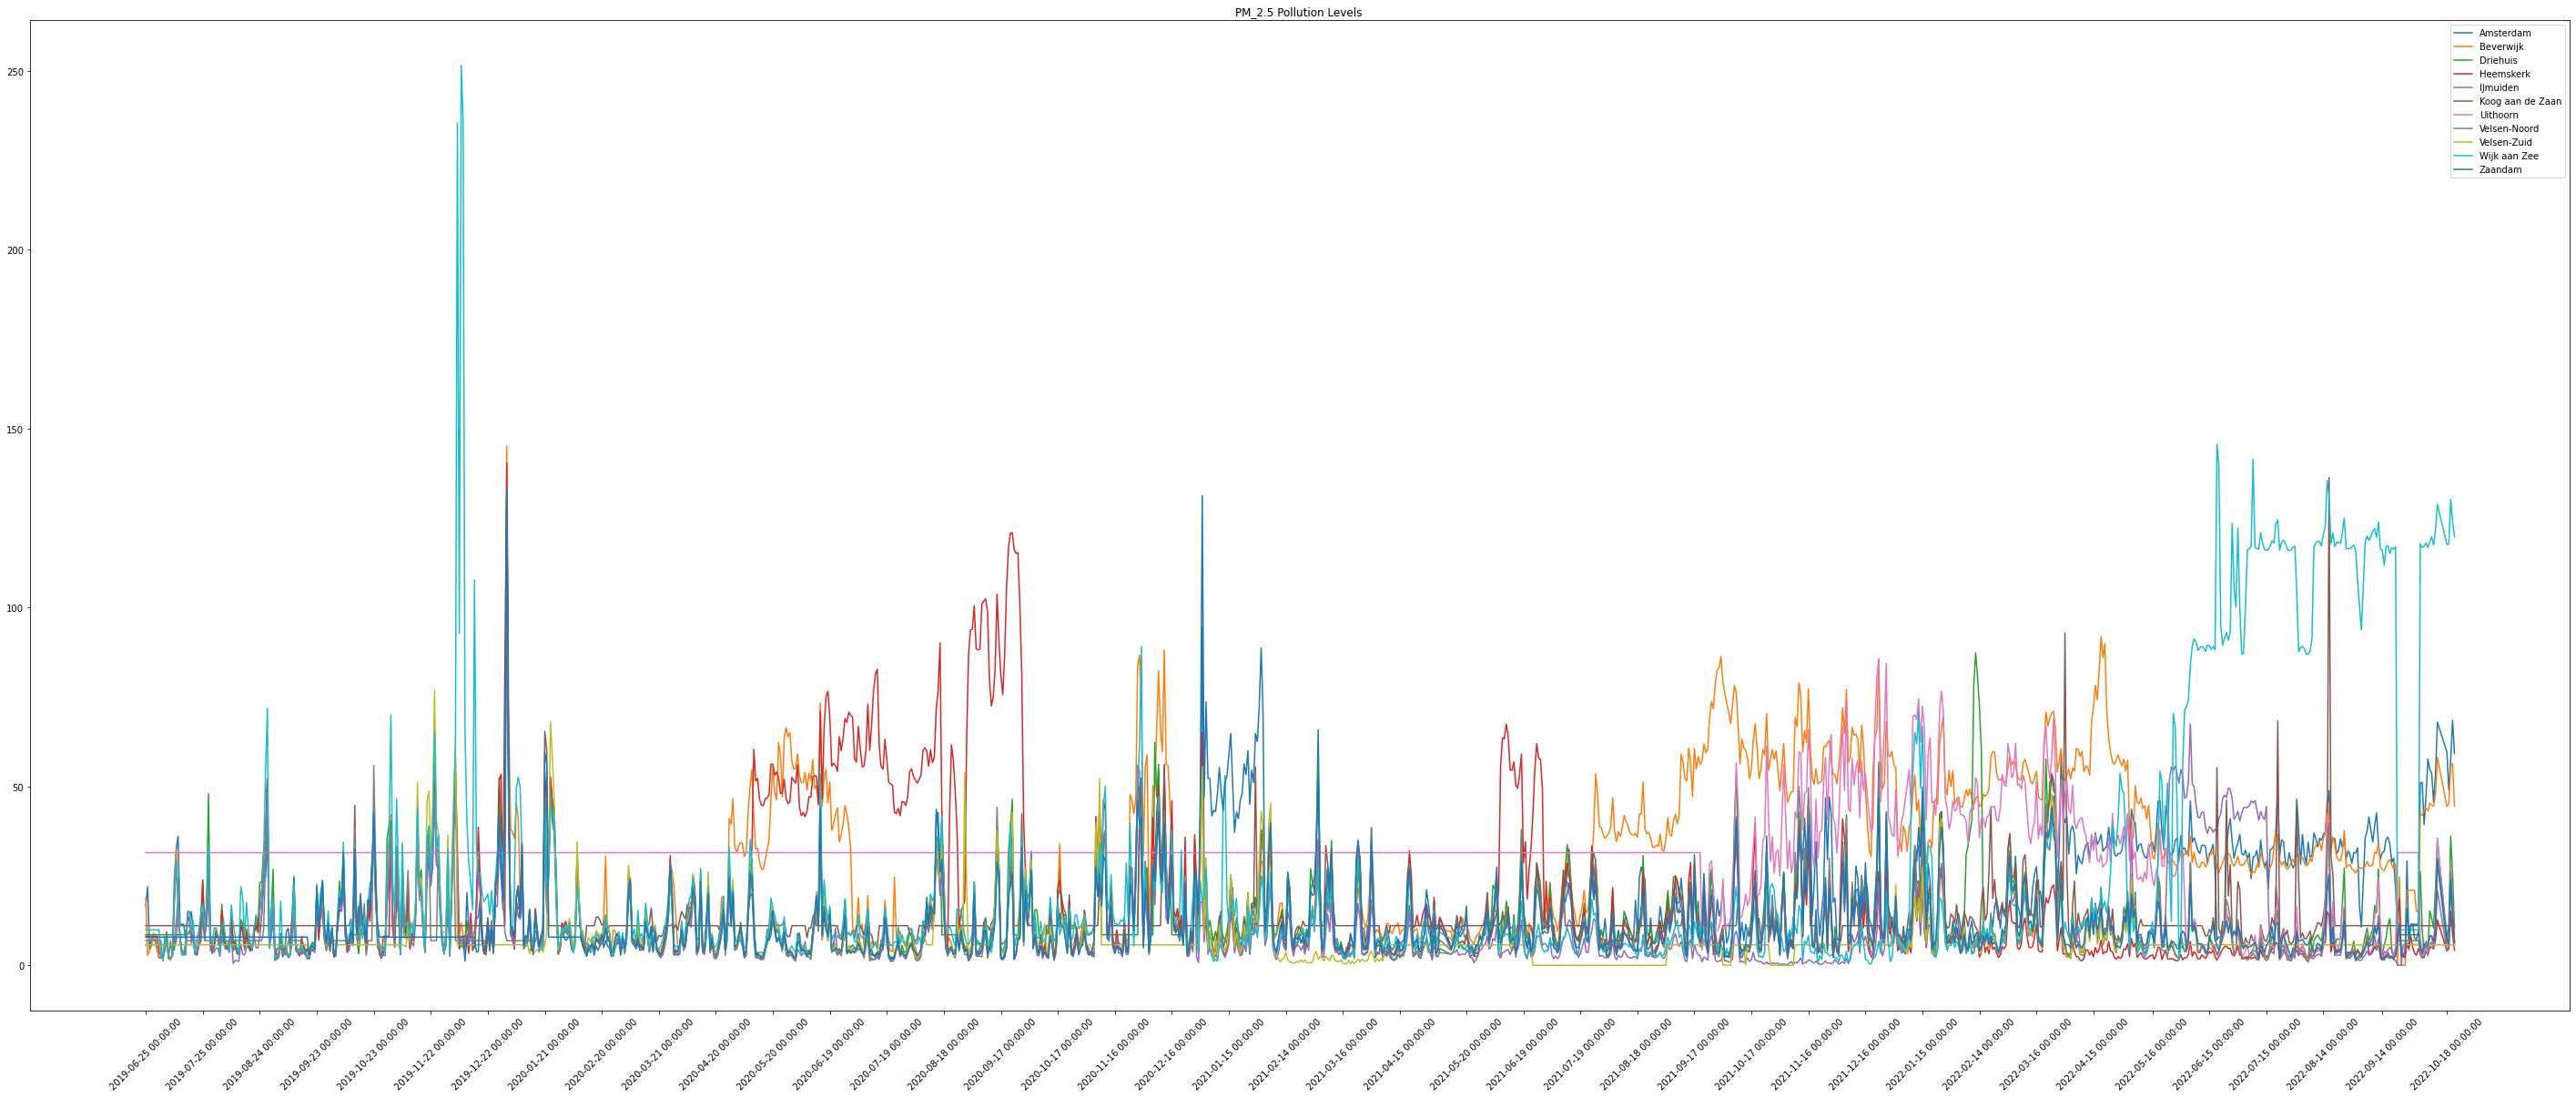

In [82]:
fig, ax = plt.subplots(1, figsize=(50,20))

ax.plot(df_pol, label=df_pol.columns)
ax.set_xticks(df_pol.index[::30])
ax.set_xticklabels(df_pol.index[::30], rotation=45)
ax.set_title("PM_2.5 Pollution Levels ")
ax.legend()
plt.show()

In [112]:
np.cos(AngleMatrix[0, 1] - df_angle.iloc[0, 1]) * df_wind.iloc[0, 1] / W[0, 1]

-0.6161596356591362

In [127]:
WW = np.zeros((len(df_pol), len(df_angle.columns), len(df_angle.columns)))
WWY = np.zeros((len(df_pol), len(df_pol.columns)))

for i in range(len(df_angle)):
    
    for j in range(len(df_angle.columns)):

        for k in range(len(df_angle.columns)):

            if W[j, k] != 0:
                WW[i, j, k] = np.cos(AngleMatrix[j, k] - df_angle.iloc[i, j]) * df_wind.iloc[i, j] / W[j, k]
            else:
                WW[i, j, k] = 0

    WWY[i, :] = np.matmul(WW[i, :, :], df_pol.iloc[i, :].to_numpy().T)


WWY_lagged = np.roll(WWY, 1, axis=0)
WWY_lagged[0, :] = 0


SWVAR = VAR(df_pol, exog=WWY_lagged).fit(maxlags=1, trend='c')
print(SWVAR.summary())


# for key in PolDict:
#     R2 = skm.r2_score(SWVAR.fittedvalues[key] + SWVAR.resid[key], SWVAR.fittedvalues[key])
#     print(F'The R-Squared of {key} is: {R2*100:.2f}%')

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Jan, 2023
Time:                     17:28:18
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    40.0158
Nobs:                     1204.00    HQIC:                   39.3486
Log likelihood:          -41984.6    FPE:                8.20054e+16
AIC:                      38.9455    Det(Omega_mle):     6.65953e+16
--------------------------------------------------------------------
Results for equation Amsterdam
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       6.922226         1.183385            5.850           0.000
exog0                       0.000690         0.004498            0.153           0.878
exog1                       0.00

/Users/main/opt/miniconda3/envs/RA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [134]:
print(SWVAR.params.to_numpy()[1:12, :])

[[ 6.89546647e-04 -3.23170583e-04  1.18817686e-03  2.23410213e-03
  -1.34966981e-03  3.52810648e-03 -3.84744541e-04  4.82310776e-03
   1.10594638e-03 -3.14071028e-02  7.29915504e-03]
 [ 5.31986173e-05 -7.40782835e-04 -1.03808581e-03  7.73963478e-04
   8.98521688e-05 -1.99376973e-03 -3.99339342e-04 -3.94908753e-04
   1.37117821e-04 -4.83995908e-03 -5.16467988e-04]
 [ 4.05271587e-04 -3.46709386e-04  8.05410414e-04 -1.79217598e-03
   6.35015910e-05  1.08482394e-03  1.78631541e-03  2.50883521e-03
   8.39879613e-04 -7.88026526e-03  1.08222203e-03]
 [ 1.32906746e-03 -8.27637017e-04 -1.84802423e-04  2.35991524e-05
  -8.87634928e-04  1.91136916e-04 -7.07669629e-04  5.20710596e-04
  -6.94967649e-04 -1.10753172e-02  1.54305227e-03]
 [ 2.21632391e-03  1.40189439e-03  2.19065051e-03  5.32399953e-04
   1.35763552e-03 -1.40356306e-03  2.08182032e-03  1.74037656e-03
   9.70696948e-04  1.73505544e-03  5.04775232e-04]
 [-1.33692096e-03 -1.13757538e-03 -1.23103971e-03 -5.07204812e-04
  -5.37585773e-04 -

In [146]:
zeta = SWVAR.params.to_numpy()[1:12, :]
windDecomp = WW

for i in range(windDecomp.shape[0]):
    windDecomp[i,:,:] = windDecomp[i,:,:] * W

x = np.linalg.solve(WW[0, :, :], zeta[:, 0])
print(x)

alpha = np.zeros((2, 1))

[-1.61694038e-18  3.99772716e-11 -1.31337553e-12 -7.87142589e-12
 -5.67375917e-11 -7.77409251e-12  3.15187197e-12  1.39298593e-10
  8.46871473e-17 -2.03258867e-16 -3.78323268e-20]
